In [1]:
import numpy as np
import pandas as pd
import pywt
from scipy.signal import welch, hilbert
from scipy.stats import skew, kurtosis, entropy, pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
CENTER_FREQ = 2.4e9  # 2.4 GHz center frequency for drone signals
SAMPLE_RATE = 40e6   # Match training data: 40 MHz
RX_GAIN = 50         # Receiver gain
TX_GAIN = -10        # Transmitter gain
BUFFER_SIZE = int(40e6 * 0.02)  # 20ms of samples at 40MHz
FFT_SIZE = 1024 * 4  # FFT size for spectral analysis

## Feature

In [3]:
def spectral_entropy(signal, fs=SAMPLE_RATE):
    """
    Compute the spectral entropy of a signal.
    Inspired by [2102.11894v1] where spectral entropy helps assess frequency randomness.
    """
    # Apply window to reduce spectral leakage
    win = np.blackman(len(signal))
    signal_win = signal * win
    
    # Use same parameters as in the main code for consistency
    f, Pxx = welch(signal_win, fs=fs, nperseg=min(1024, len(signal)))
    
    # Normalize and compute entropy
    Pxx_norm = Pxx / np.sum(Pxx) if np.sum(Pxx) > 0 else Pxx
    return entropy(Pxx_norm)

In [4]:

def median_frequency(signal, fs=SAMPLE_RATE):
    """
    Compute median frequency using the Welch power spectral density.
    This feature is referenced in several RF fingerprinting studies.
    """
    # Apply window to reduce spectral leakage
    win = np.blackman(len(signal))
    signal_win = signal * win
    
    f, Pxx = welch(signal_win, fs=fs, nperseg=min(1024, len(signal)))
    cumulative_power = np.cumsum(Pxx)
    
    # Handle edge case of all zeros
    if cumulative_power[-1] == 0:
        return 0.0
        
    half_power = cumulative_power[-1] / 2.0
    median_freq = f[np.searchsorted(cumulative_power, half_power)]
    return median_freq

In [5]:
def extract_additional_features(signal_data, fs=SAMPLE_RATE):
    """
    Extract additional features from complex IQ samples.
    Features included:
      - Phase-domain: Mean and standard deviation of the phase.
      - Frequency-domain: Median frequency and spectral entropy.
      - Wavelet-domain: Energy of subbands via discrete wavelet transform.
      - Hilbert transform: Envelope statistics.
    
    Adapted for PlutoSDR data format.
    """
    # Ensure adequate signal length for feature extraction
    if len(signal_data) < 128:
        # Pad if too short
        padding = np.zeros(128 - len(signal_data), dtype=complex)
        signal_data = np.concatenate([signal_data, padding])
    
    # Compute magnitude and phase
    mag = np.abs(signal_data)
    phases = np.angle(signal_data)
    
    # Phase features
    mean_phase = np.mean(phases)
    std_phase = np.std(phases)
    
    # Frequency-domain features - using magnitude spectrum
    med_freq = median_frequency(mag, fs)
    spec_entropy = spectral_entropy(mag, fs)
    
    # Wavelet transform features
    # Use only first 1024 samples for wavelet to manage computational load
    analysis_length = min(1024, len(mag))
    # Ensure the length is divisible by 2^level for the wavelet transform
    analysis_length = analysis_length - (analysis_length % 8)  # For a 3-level decomposition
    
    coeffs = pywt.wavedec(mag[:analysis_length], 'db4', level=3)
    wavelet_energies = [np.sum(c ** 2) / len(c) if len(c) > 0 else 0.0 for c in coeffs]
    
    # Hilbert transform for envelope analysis
    analytic_signal = hilbert(mag)
    envelope = np.abs(analytic_signal)
    mean_envelope = np.mean(envelope)
    std_envelope = np.std(envelope)
    
    # Additional drone-specific features
    # Energy in specific bands (common for drone control frequencies)
    fft_vals = np.fft.fft(signal_data)
    fft_mag = np.abs(fft_vals)
    freq_axis = np.fft.fftfreq(len(signal_data), d=1/fs)
    
    # Check energy in typical drone control frequency bands
    # Control frequencies often found at 50-250kHz offsets
    control_bands = [(50e3, 100e3), (100e3, 150e3), (150e3, 200e3), (200e3, 250e3)]
    band_energies = []
    
    for low, high in control_bands:
        # Convert frequency range to indices
        low_idx = np.argmin(np.abs(freq_axis - low))
        high_idx = np.argmin(np.abs(freq_axis - high))
        # Calculate energy in band
        band_energy = np.sum(fft_mag[low_idx:high_idx+1]**2) / (high_idx - low_idx + 1)
        band_energies.append(band_energy)
    
    # Combine all features
    additional_feats = [
        mean_phase, std_phase, 
        med_freq, spec_entropy, 
        *wavelet_energies, 
        mean_envelope, std_envelope,
        *band_energies
    ]
    
    return additional_feats

In [6]:
def extract_features(signal_data, fs=SAMPLE_RATE, n_fft=FFT_SIZE):
    """
    Extract features for drone detection, adapted for the PlutoSDR data.
    This replaces the original extract_features function in the script.
    
    Parameters:
    - signal_data: Complex IQ samples captured from the SDR
    - fs: Sampling frequency (default based on SDR configuration)
    - n_fft: FFT size for spectral analysis
    
    Returns:
    - Feature vector for classification
    """
    # Ensure signal_data is the right size for feature extraction
    if len(signal_data) > n_fft:
        # If signal is too large, take the first n_fft samples
        signal_data = signal_data[:n_fft]
    elif len(signal_data) < n_fft:
        # If signal is too small, pad with zeros
        padding = np.zeros(n_fft - len(signal_data), dtype=complex)
        signal_data = np.concatenate([signal_data, padding])
    
    # Calculate magnitude and basic statistics
    mag = np.abs(signal_data)
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    skew_mag = skew(mag)
    kurtosis_mag = kurtosis(mag)
    
    # Calculate signal energy (normalized by length)
    energy = np.sum(mag ** 2) / len(mag)
    
    # Apply window function for better spectral estimation
    win = np.blackman(len(signal_data))
    windowed_data = signal_data * win
    
    # Compute FFT and get peak frequency
    fft_vals = np.fft.fft(windowed_data, n=n_fft)
    fft_mag = np.abs(fft_vals)[:n_fft // 2]
    freqs = np.fft.fftfreq(n_fft, d=1/fs)[:n_fft // 2]
    peak_freq = freqs[np.argmax(fft_mag)] if len(fft_mag) > 0 else 0.0
    
    # Get magnitude spectrum as used in the original code
    # This provides a base feature set similar to the original implementation
    dft = np.fft.fft(mag, n=n_fft)
    magnitude_spectrum = np.abs(dft[:n_fft//2])
    
    # Normalize magnitude spectrum
    if np.max(magnitude_spectrum) > 0:
        magnitude_spectrum = magnitude_spectrum / np.max(magnitude_spectrum)
    
    # Calculate spectral flatness (Wiener entropy)
    # Good for distinguishing between noise-like and tonal signals
    if np.prod(fft_mag) > 0 and np.mean(fft_mag) > 0:
        spectral_flatness = np.exp(np.mean(np.log(fft_mag + 1e-10))) / np.mean(fft_mag)
    else:
        spectral_flatness = 0
    
    # Basic vector of features
    basic_features = [mean_mag, std_mag, skew_mag, kurtosis_mag, energy, peak_freq, spectral_flatness]
    
    # Get additional features for better classification
    additional_feats = extract_additional_features(signal_data, fs)
    
    # Combine all features
    return np.concatenate([basic_features, additional_feats])

## Process data

In [ ]:


def process_dataset(data_path, label, fs=SAMPLE_RATE, chunk_size=100):
    """
    Process a dataset of SDR captures and extract features.
    
    Parameters:
    - data_path: Path to the .npz file containing SDR data
    - label: Class label (0 for background, 1 for drone)
    - fs: Sampling frequency
    - chunk_size: Number of samples to process at once for memory efficiency
    
    Returns:
    - X: Features array
    - y: Labels array
    """
    try:
     
        data = np.load(data_path)
        
       
        print(f"Available keys in {data_path}: {data.files}")
        
       
        key = 'iq_samples' if 'iq_samples' in data.files else data.files[0]
        iq_samples = data[key]
        
       
        print(f"Data shape: {iq_samples.shape}")
        
     
        features_list = []
        labels_list = []
        
   
        total_samples = iq_samples.shape[0]
        for start_idx in range(0, total_samples, chunk_size):
            end_idx = min(total_samples, start_idx + chunk_size)
            print(f"Processing samples {start_idx} to {end_idx} of {total_samples}")
            
            # Process each sample in the chunk
            for i in range(start_idx, end_idx):
                sample = iq_samples[i]
                features = extract_features(sample, fs=fs)
                features_list.append(features)
                labels_list.append(label)
            
        return np.array(features_list), np.array(labels_list)
    
    except Exception as e:
        print(f"Error processing dataset {data_path}: {e}")
        import traceback
        traceback.print_exc()
        return np.array([]), np.array([])



In [8]:

background_path = r"drone_dataset\\background_20250414_142850.npz"

drone_path = r"drone_dataset\\drone_data_20250414_144053.npz"

In [9]:



print(f"Processing background dataset: {background_path}")
X_bg, y_bg = process_dataset(background_path, label=0, fs=SAMPLE_RATE)

print(f"Processing drone dataset: {drone_path}")
X_drone, y_drone = process_dataset(drone_path, label=1, fs=SAMPLE_RATE)

Processing background dataset: drone_dataset\\background_20250414_142850.npz
Available keys in drone_dataset\\background_20250414_142850.npz: ['iq_samples']
Data shape: (500, 800000)
Processing samples 0 to 100 of 500


c:\Users\Lenovo\Desktop\GD-drone\gddrone\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Processing samples 100 to 200 of 500
Processing samples 200 to 300 of 500
Processing samples 300 to 400 of 500
Processing samples 400 to 500 of 500
Processing drone dataset: drone_dataset\\drone_data_20250414_144053.npz
Available keys in drone_dataset\\drone_data_20250414_144053.npz: ['iq_samples']
Data shape: (500, 800000)
Processing samples 0 to 100 of 500
Processing samples 100 to 200 of 500
Processing samples 200 to 300 of 500
Processing samples 300 to 400 of 500
Processing samples 400 to 500 of 500


In [13]:
X = np.vstack([X_bg, X_drone])
y = np.concatenate([y_bg, y_drone])

In [22]:
y.size

1000

In [24]:
import pandas as pd

print("Class distribution:\n", pd.Series(y).value_counts())


Class distribution:
 0    500
1    500
Name: count, dtype: int64


## Training 

In [16]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os

In [ ]:
if len(X_bg) > 0 and len(X_drone) > 0:
   
    
    print(f"Combined dataset shape: {X.shape}")
    print(f"Class distribution: {np.unique(y, return_counts=True)}")
    
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
   
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    )
    
    print("Training model...")
    model.fit(X_train, y_train)
    
  
    os.makedirs('models', exist_ok=True)
    model_path = 'models/xgboost_model_drone_detection.joblib'
    model.save_model(model_path)
    print(f"Model saved to {model_path}")
    
   
        
else:
    print("Error: One or both datasets could not be processed")

Combined dataset shape: (1000, 21)
Class distribution: (array([0, 1]), array([500, 500]))
Training model...
Model saved to models/xgboost_model_drone_detection.joblib


c:\Users\Lenovo\Desktop\GD-drone\gddrone\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [12:26:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


## Eval

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_pred = model.predict(X_test)
    
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
    

feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
importance = model.feature_importances_
    

indices = np.argsort(importance)[::-1]
print("\nTop 10 most important features:")
for i in range(min(10, X.shape[1])):
    print(f"{feature_names[indices[i]]}: {importance[indices[i]]:.4f}")


Model Evaluation:
Accuracy: 0.8800
Precision: 0.9082
Recall: 0.8558
F1 Score: 0.8812
Confusion Matrix:
[[87  9]
 [15 89]]

Top 10 most important features:
Feature_0: 0.1864
Feature_15: 0.1778
Feature_11: 0.0997
Feature_3: 0.0966
Feature_16: 0.0394
Feature_6: 0.0365
Feature_1: 0.0357
Feature_2: 0.0331
Feature_5: 0.0323
Feature_14: 0.0314


# prediction on saved csv

In [19]:
import pandas as pd
import numpy as np
import joblib
import pywt
from scipy.signal import welch, hilbert
from scipy.stats import skew, kurtosis, entropy

# Load your saved model
model_path = 'xgboost_model_drone_detection.joblib'
model = joblib.load(model_path)

# Function to process CSV data into complex IQ samples
def process_csv_data(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Create complex IQ samples
    i_values = df['I'].values
    q_values = df['Q'].values
    iq_samples = i_values + 1j * q_values
    
    return iq_samples

# Using the same feature extraction functions as in your training code
def spectral_entropy(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    Pxx_norm = Pxx / np.sum(Pxx) if np.sum(Pxx) > 0 else Pxx
    return entropy(Pxx_norm)

def median_frequency(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    cumulative_power = np.cumsum(Pxx)
    half_power = cumulative_power[-1] / 2.
    median_freq = f[np.searchsorted(cumulative_power, half_power)]
    return median_freq

def extract_features(iq_data, fs=1.0):
    mag = np.abs(iq_data)
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    skew_mag = skew(mag)
    kurtosis_mag = kurtosis(mag)
    energy = np.sum(mag ** 2)
    
    N = len(iq_data)
    fft_vals = np.fft.fft(iq_data)
    fft_mag = np.abs(fft_vals)[:N // 2]
    freqs = np.fft.fftfreq(N, d=1/fs)[:N // 2]
    peak_freq = freqs[np.argmax(fft_mag)] if len(fft_mag) > 0 else 0.0
    
    return [mean_mag, std_mag, skew_mag, kurtosis_mag, energy, peak_freq]

def extract_additional_features(iq_data, fs=1.0):
    # Compute phase features
    phases = np.angle(iq_data)
    mean_phase = np.mean(phases)
    std_phase = np.std(phases)
    
    # Frequency-domain features
    mag = np.abs(iq_data)
    med_freq = median_frequency(mag, fs)
    spec_entropy = spectral_entropy(mag, fs)
    
    # Wavelet transform features
    coeffs = pywt.wavedec(mag, 'db4', level=3)
    wavelet_energies = [np.sum(c ** 2) for c in coeffs]
    
    # Hilbert transform features
    analytic_signal = hilbert(mag)
    envelope = np.abs(analytic_signal)
    mean_envelope = np.mean(envelope)
    std_envelope = np.std(envelope)
    
    additional_feats = [mean_phase, std_phase, med_freq, spec_entropy] + wavelet_energies + [mean_envelope, std_envelope]
    return additional_feats

def combine_features(iq_data, fs=1.0):
    base_feats = extract_features(iq_data, fs)
    extra_feats = extract_additional_features(iq_data, fs)
    return base_feats + extra_feats

# Main function to process CSV and make prediction
def predict_drone_from_csv(csv_file, threshold=0.5):
    # Process the CSV data
    iq_samples = process_csv_data(csv_file)
    
    # Extract features
    features = combine_features(iq_samples)
    
    # Reshape features for model input
    features_array = np.array(features).reshape(1, -1)
    
    # Get prediction probability
    probability = model.predict_proba(features_array)[0][1]
    
    # Make prediction
    prediction = 1 if probability > threshold else 0
    
    # Return result
    return {
        'probability': probability,
        'prediction': prediction,
        'result': 'Drone Detected' if prediction == 1 else 'No Drone Detected'
    }

# Example usage
csv_file = 'Data\\pluto_sdr_iq_data_20250320_122718.csv'  
result = predict_drone_from_csv(csv_file)
print(f"Prediction: {result['result']} (Probability: {result['probability']:.4f})")

Prediction: No Drone Detected (Probability: 0.1913)


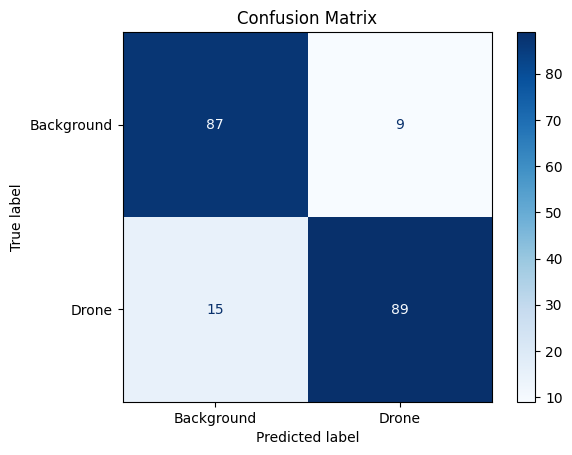

Classification Report:
               precision    recall  f1-score   support

  Background       0.85      0.91      0.88        96
       Drone       0.91      0.86      0.88       104

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



In [20]:
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Drone'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


report = classification_report(y_test, y_pred, target_names=['Background', 'Drone'])
print("Classification Report:\n", report)